In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from algos.alg_fpd_extended import FpdExtended
import numpy as np
from bitarray import bitarray, util
import tqdm
import struct
from shapely.geometry import shape
from collections import defaultdict
import math
import random
from algos.fpd_extended_lib.compress import *
import pyae


100%|██████████| 10259/10259 [00:05<00:00, 1731.65it/s]


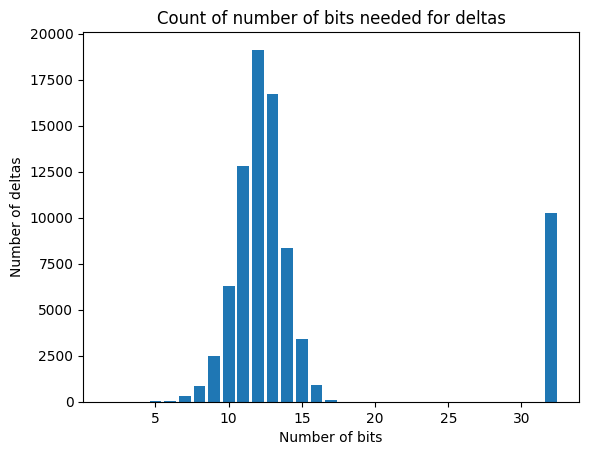

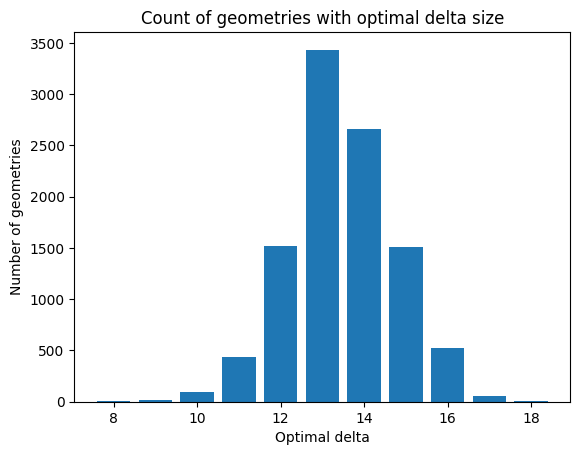

In [2]:
fpd = FpdExtended()

import bench_utils
df, unary_idxs = bench_utils.read_dataset("data/lund_building_highway.json")
#df, unary_idxs = bench_utils.read_dataset("data/world.json")
unary_idxs = list(set(unary_idxs))
bins = []

bit_counts = defaultdict(int)
bit_count_by_delta_size = defaultdict(int)
deltas_fp = []
deltas_long = []
geom_optimal_sizes = {}
# Compress files, benchmark unaries
for idx in tqdm.tqdm(unary_idxs): # List of single idxs
    opt_size, bit_count, deltas = calculate_delta_size(shape(df.iloc[idx]), True)
    geom_optimal_sizes[idx] = opt_size
    deltas_fp += deltas[0]
    deltas_long += deltas[1]
    for bit_count_key in bit_count:
        bit_counts[bit_count_key] += bit_count[bit_count_key]
    bit_count_by_delta_size[opt_size] += 1
    bins.append(fpd.compress(shape(df.iloc[idx]))[1])
plt.bar(bit_counts.keys(), bit_counts.values());
plt.title("Count of number of bits needed for deltas")
plt.xlabel("Number of bits")
plt.ylabel("Number of deltas")
plt.show()

plt.bar(bit_count_by_delta_size.keys(), bit_count_by_delta_size.values());
plt.title("Count of geometries with optimal delta size")
plt.xlabel("Optimal delta")
plt.ylabel("Number of geometries")
plt.show()
deltas_fp = np.array(deltas_fp)

Percentage of total FP deltas within filtered 0.7848072590125392
Percentage of total FP deltas (but removed excessive values) within filtered 0.8975631958546321
Percentage of total LONG + ZZ deltas within filtered 0.8513788205329154
Percentage of total LONG + ZZ deltas (but removed excessive values) within filtered 0.8513788205329154


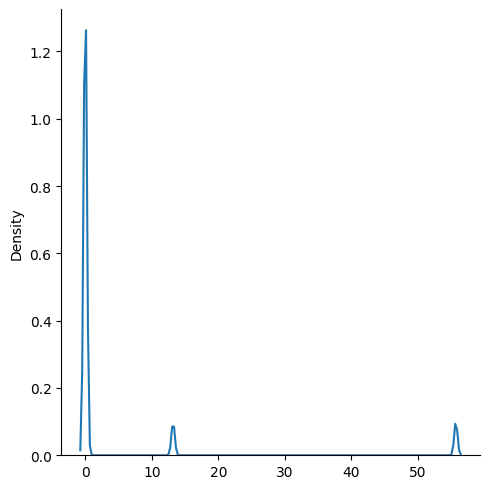

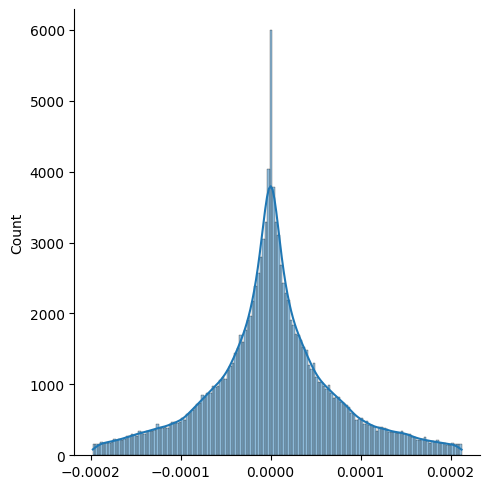

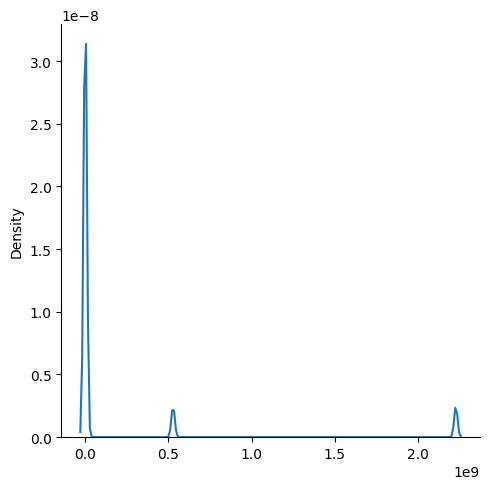

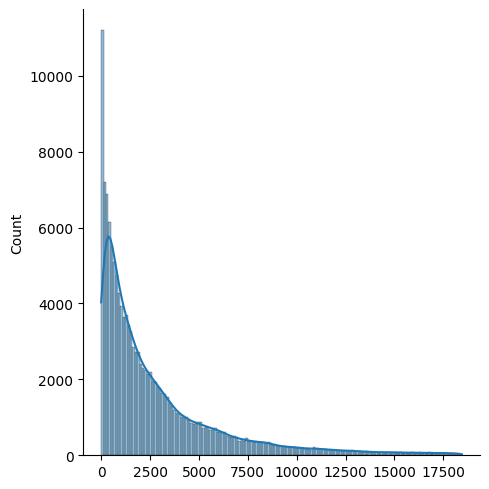

In [3]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

OUTLIER_THRESHOLD = 2.5
filtered = np.array(deltas_fp)
filtered = filtered[~is_outlier(filtered, thresh=OUTLIER_THRESHOLD)]
sns.displot(deltas_fp, kind="kde", bw_adjust=.2)
#sns.displot(filtered, kind="kde", bw_adjust=.05)
sns.displot(filtered, kde=True)
print("Percentage of total FP deltas within filtered", len(filtered) / len(deltas_fp))
print("Percentage of total FP deltas (but removed excessive values) within filtered", len(filtered) / len(deltas_fp[deltas_fp < 10]))

OUTLIER_THRESHOLD = 6
deltas_long_np = np.array(deltas_long, dtype=np.float64)
filtered = np.array(deltas_long_np)
filtered = filtered[~is_outlier(filtered, thresh=OUTLIER_THRESHOLD)]
sns.displot(deltas_long_np, kind="kde", bw_adjust=.2)
#sns.displot(filtered, kind="kde", bw_adjust=.05)
sns.displot(filtered, kde=True)
print("Percentage of total LONG + ZZ deltas within filtered", len(filtered) / len(deltas_long_np))
print("Percentage of total LONG + ZZ deltas (but removed excessive values) within filtered", len(filtered) / len(deltas_long_np[deltas_long_np < 4 * pow(10, 18)]))

In [4]:
for i in range(1):
    idx = random.randint(0, len(deltas_fp))
    print("---")
    print("Delta in FP and LONG:    ", f'{deltas_fp[idx]:.14f}', '        ', deltas_long[idx])
    print("Converting to f32:       ", f'{struct.unpack("!f", struct.pack("!f", deltas_fp[idx]))[0]:.14f}')
    print("Required bits:           ", math.ceil(math.log2(deltas_long[idx] + 1)))
    bin = util.int2ba(deltas_long[idx], length=64)
    print("ZZ-encoded:              ", end=None)
    util.pprint(bin, width=200)

    bin = bitarray()
    print("FP directly to bin:      ", end=None)
    bin.frombytes(struct.pack("!d", deltas_fp[idx]))
    util.pprint(bin, width=200)

    bin = bitarray()
    print("FP32 directly to bin:    ", end=None)
    bin.frombytes(struct.pack("!f", deltas_fp[idx]))
    
    util.pprint(bin, width=200)

---
Delta in FP and LONG:     13.21667760000000          528667104
Converting to f32:        13.21667766571045
Required bits:            29
ZZ-encoded:              
bitarray('00000000 00000000 00000000 00000000 00011111 10000010 11010001 11100000')
FP directly to bin:      
bitarray('01000000 00101010 01101110 11110000 01011101 11001011 10001101 00110010')
FP32 directly to bin:    
bitarray('01000001 01010011 01110111 10000011')


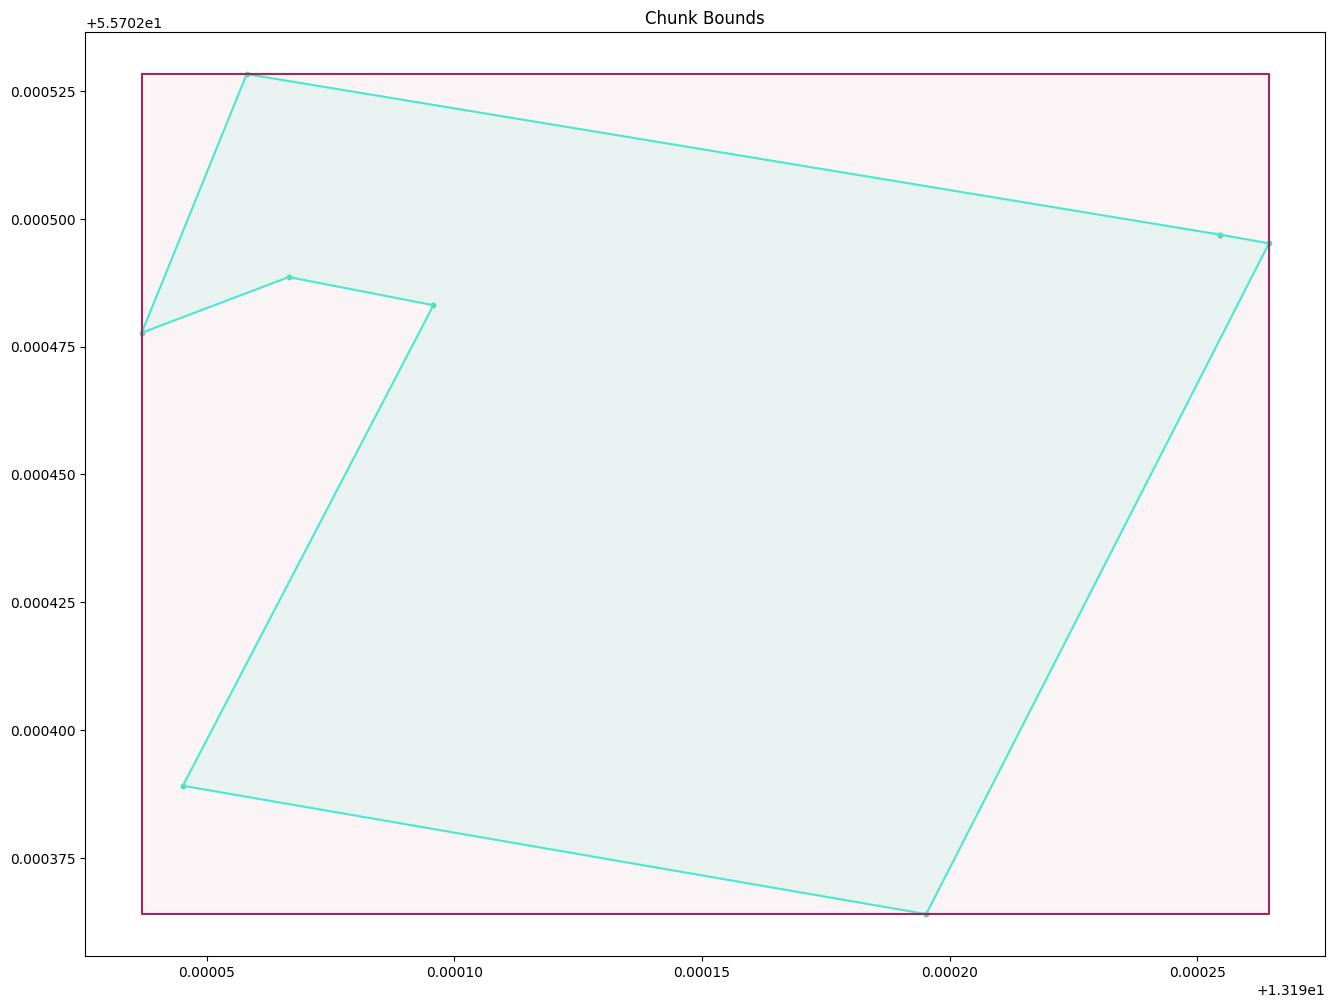

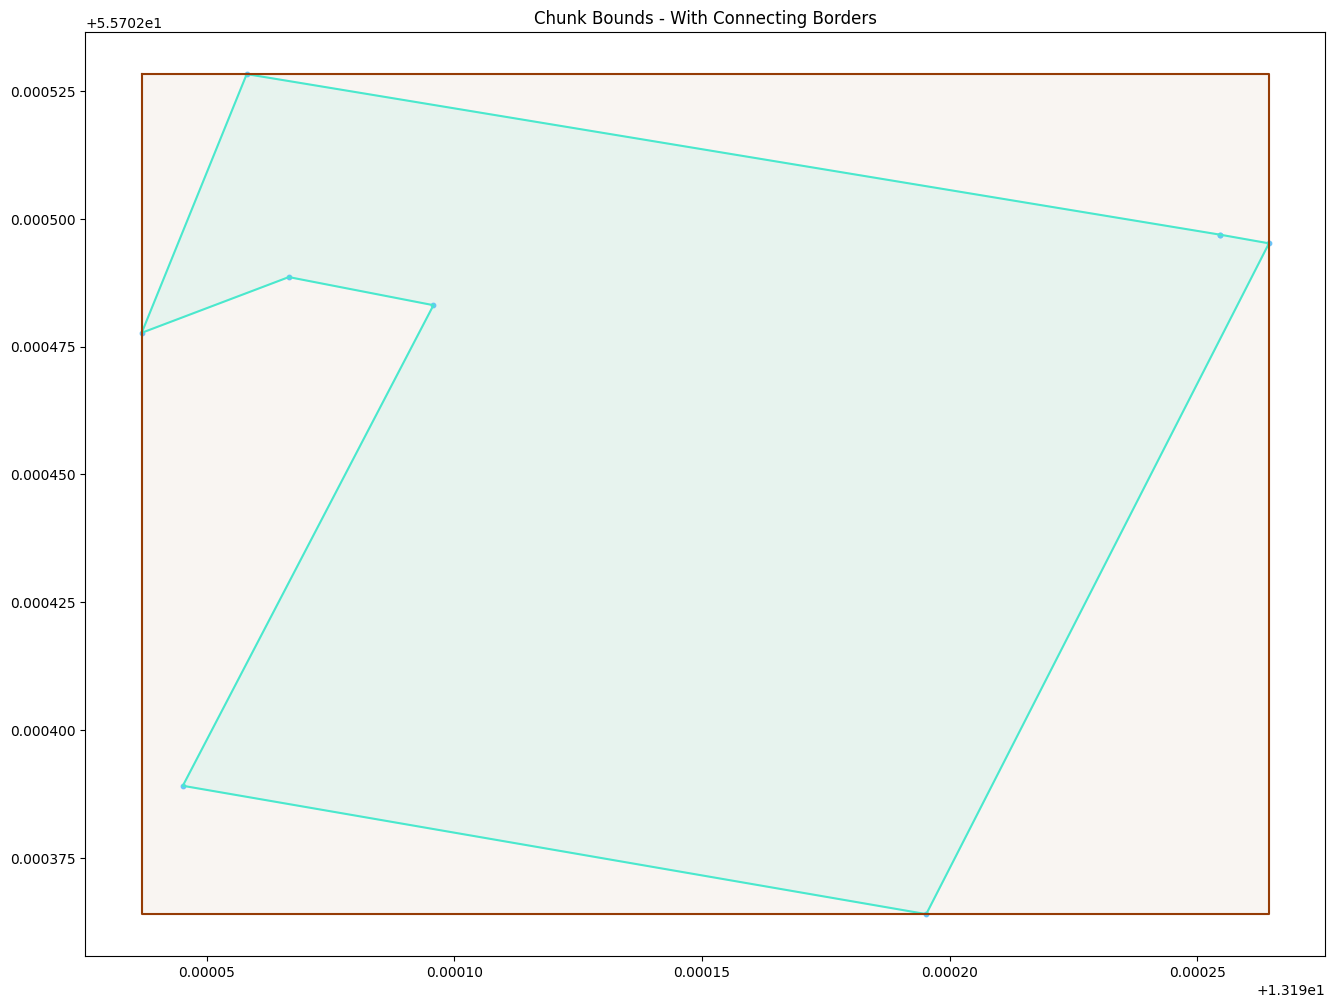

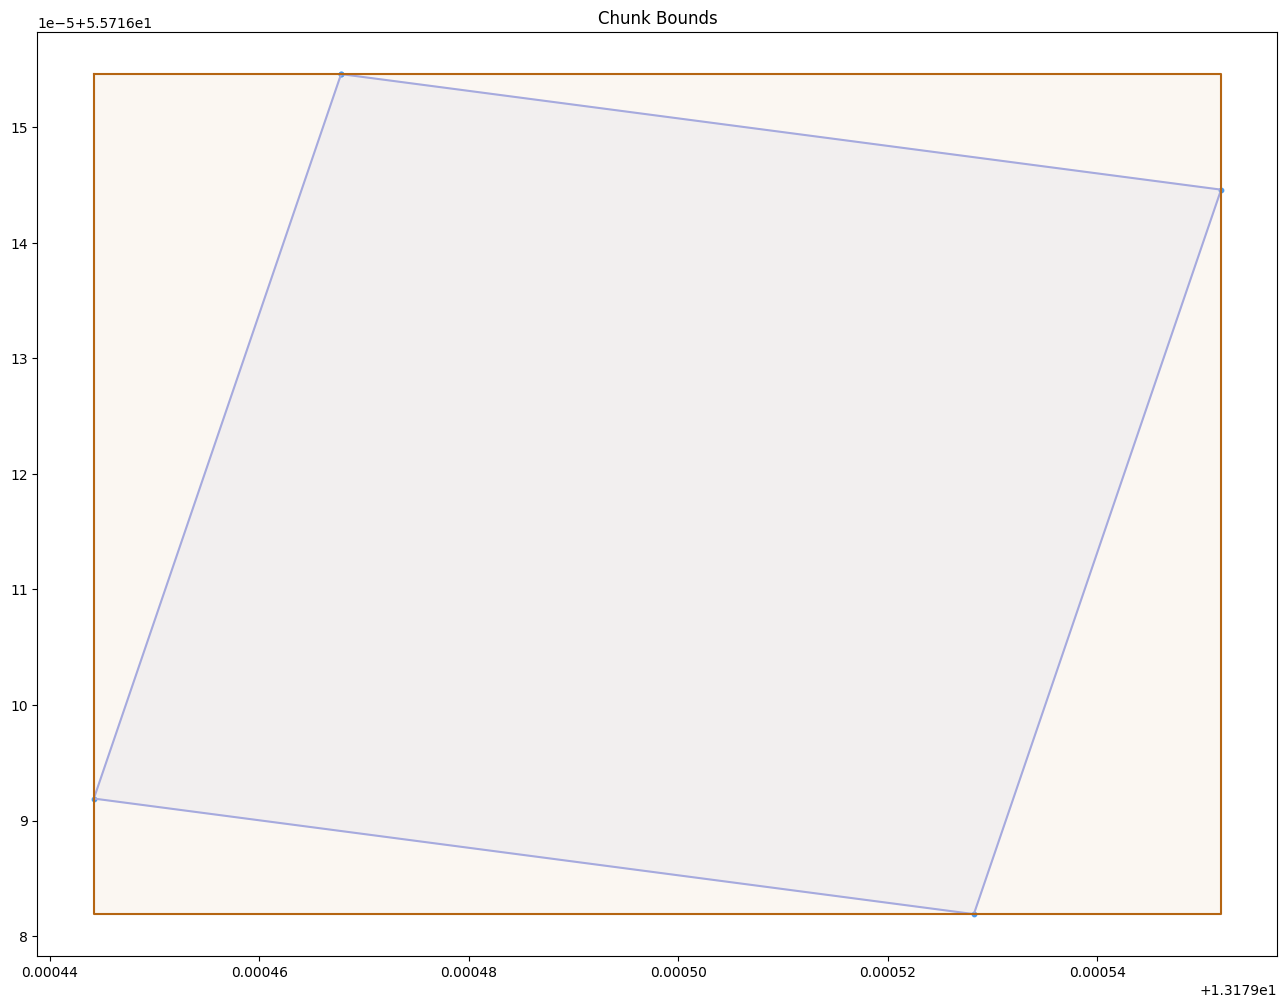

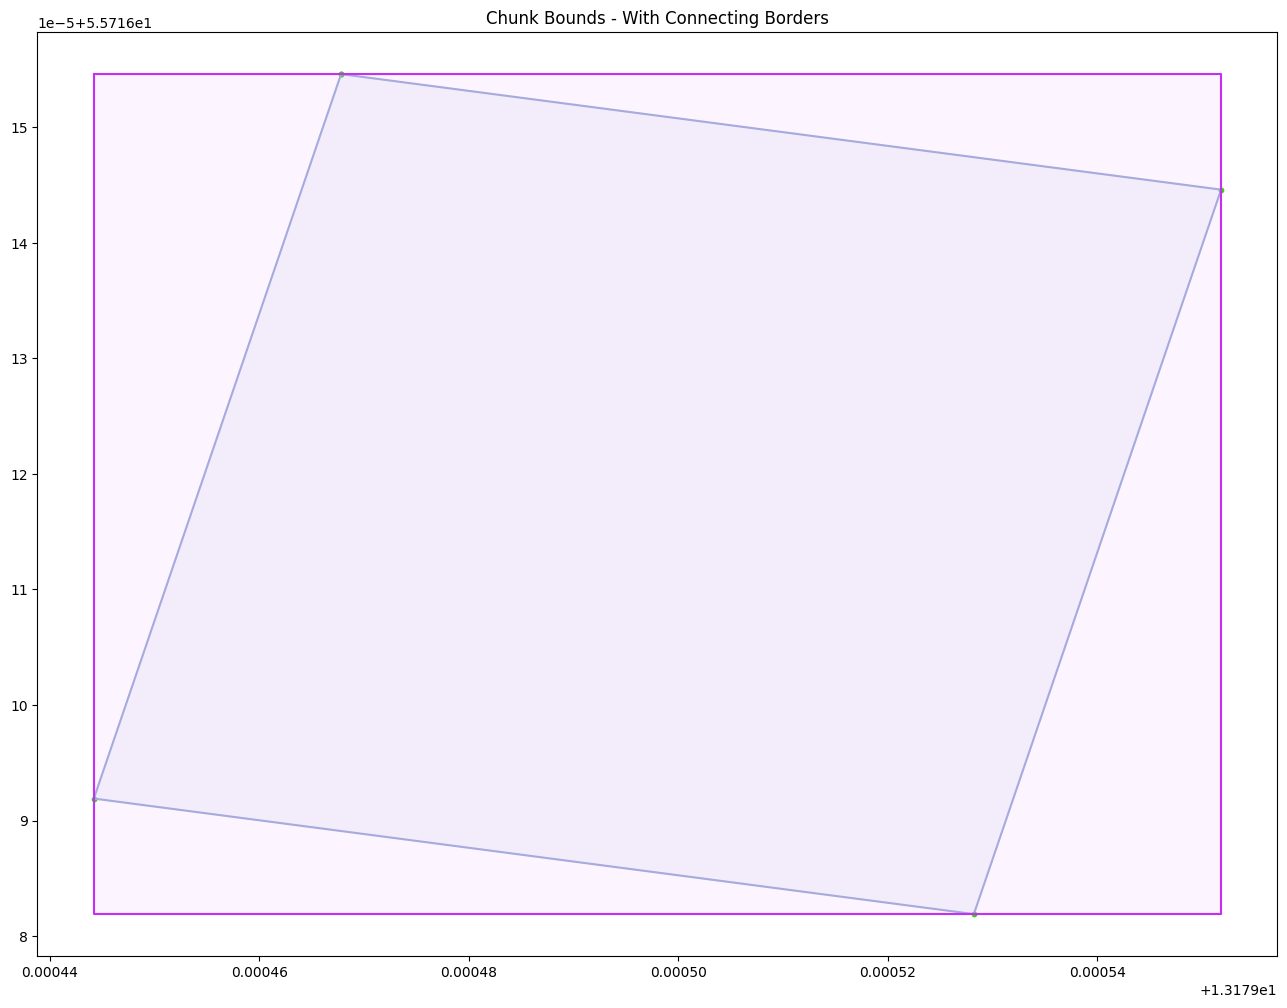

In [5]:
if True:
    from intersection.plotting import *

    for i in range(2):
        idx = random.randint(0, len(bins))
        plot_chunks_bounds(bins[idx], include_next_chunk_start=False)
        plot_chunks_bounds(bins[idx], include_next_chunk_start=True)

## Entrpoy Encoding Analysis

In [6]:
import warnings
from collections import defaultdict
import tqdm
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from algos.alg_fpd_extended import FpdExtended
import numpy as np
from bitarray import bitarray, util
import tqdm
import struct
from shapely.geometry import shape
from collections import defaultdict
import math
import random
import bench_utils

from algos.fpd_extended_lib.compress import *

In [7]:
PREFIX_LENGTH = 6
PERCENTILE_MAX = 0.51
PLOT_CDF_FREQS = True
SHOW_GRAPHS = True
HUFFMAN = True

AE = None #arithmetic encoding instance
df, unary_idxs = bench_utils.read_dataset("data/lund_building_highway.json")
#df, unary_idxs = bench_utils.read_dataset("data/world.json")
unary_idxs = list(set(unary_idxs))

In [8]:
#PLOT_HELPERS
def set_subplt_fig_attributes(fig, title, y_label, x_label, x_size, y_size):
    fig.suptitle(title)
    fig.supylabel(y_label)
    fig.supxlabel(x_label)
    fig.tight_layout()
    fig.set_figheight(y_size)
    fig.set_figwidth(x_size)
    plt.subplots_adjust(top=0.8, bottom=0.2, left=0.1)
    plt.tight_layout()

def set_fig_attributes(title, y_label, x_label):
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.tight_layout()

### General delta analysis

In [9]:
def get_delta_frequencies(geom_df,unary_idxs):
    #Created stats variables for all deltas in general, by geometry and by bits delta is encoded with (optimal size)
    deltas = []
    deltas_by_bits = defaultdict(list)
    delta_freqs_by_geometry = defaultdict(dict)
    geom_optimal_sizes = {}
    for idx in tqdm.tqdm(unary_idxs): # List of single idxs
        opt_size, _, delta_list = calculate_delta_size(shape(geom_df.iloc[idx]), True)
        geom_optimal_sizes[idx] = opt_size
        for delta in delta_list[1]:
            
            #If coordinate not delta_encoded
            if delta != 0 and math.log2(delta) > opt_size:
                continue

            deltas.append((delta, uint_to_ba(delta, opt_size).to01())) # deltas = [(delta, delta_01)...]
            deltas_by_bits[opt_size].append(delta)

            if delta in delta_freqs_by_geometry[idx]:
                delta_freqs_by_geometry[idx][delta] += 1
            else:
                delta_freqs_by_geometry[idx][delta] = 1
          
                
    return deltas, deltas_by_bits, delta_freqs_by_geometry, geom_optimal_sizes

In [10]:
deltas, deltas_by_bits, delta_freqs_by_geometry, geom_optimal_sizes = get_delta_frequencies(df, unary_idxs)

100%|██████████| 10259/10259 [00:01<00:00, 5390.02it/s]


In [11]:
def plot_delta_distribution(deltas, deltas_by_bits):
    HEIGHT = math.ceil(len(deltas_by_bits.keys()) / 4) 
    WIDTH = 4
    
    #Plot delta distribution for all 
    plt.figure(figsize=(HEIGHT * 3, HEIGHT))
    plt.title("Cumulative kernel density estimate of deltas")
    ax = sns.kdeplot(deltas, cumulative=True)
    ax.set_xlim(0, max(deltas))
    plt.show()

    fig, axes = plt.subplots(HEIGHT, WIDTH)

    for idx, delta_bit_len in enumerate(sorted(deltas_by_bits.keys())):
        curr_height, curr_width = idx // WIDTH, idx % WIDTH
        current_axis = axes[curr_height, curr_width]

        current_axis.set_title("Geometry delta size: {}".format(delta_bit_len), pad=15, fontsize=10)
        ax = sns.kdeplot(deltas_by_bits[delta_bit_len], ax=current_axis, cumulative=False)
        current_axis.set_xlim(0, max(deltas_by_bits[delta_bit_len]))
        current_axis.set(ylabel=None)

    fig.supylabel('Density')
    fig.supxlabel('Delta values')
    fig.suptitle('Distribution of delta values for geometries with different delta bit lengths', y=1.02)
    fig.set_figwidth(HEIGHT * 3)
    fig.set_figheight(HEIGHT * 3)

    plt.tight_layout()

    plt.show()

RuntimeError: Cumulative KDE evaluation requires scipy

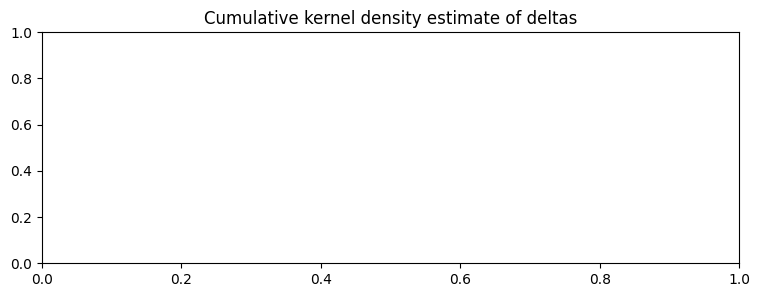

In [12]:
if SHOW_GRAPHS:
    plot_delta_distribution([delta[0] for delta in deltas], deltas_by_bits)

### Generate Entropy codes

In [ ]:
def encode(msg, codes):
    if HUFFMAN:
        return codes[msg].to01()
    else:
        _, _ , interval_min_value, interval_max_value = codes.encode(msg=msg, probability_table=codes.probability_table)
        binary_code, _ = codes.encode_binary(float_interval_min=interval_min_value, float_interval_max=interval_max_value)
        return binary_code[2:]
    

def get_entropy_codes(frequency_list):
    if HUFFMAN:
        return util.canonical_huffman(frequency_list)[0]
    else:
        return pyae.ArithmeticEncoding(frequency_table=frequency_list, save_stages=False)
    
def get_bit_seq_freqs(prefix_len):
    freq_by_bits, encoding_freq_by_bits, freq, encoding_freq = defaultdict(dict), defaultdict(dict), defaultdict(int), defaultdict(int)
    bit_variants= ["0","1"]     

    for delta in deltas:
        bits = delta[1]
        bit_len = len(bits)

        delta_bits = bits if prefix_len == None else bits[:prefix_len]
        freq[delta_bits] += 1
       
        if not HUFFMAN:
            for key in bit_variants:
                encoding_freq[key] += int(delta_bits.count(key))
                if key in encoding_freq_by_bits[bit_len]:
                    encoding_freq_by_bits[bit_len][key] += int(delta_bits.count(key))
                else:
                    encoding_freq_by_bits[bit_len][key] = int(delta_bits.count(key))
        else:
            encoding_freq[delta_bits] += 1/bit_len

        if delta_bits in freq_by_bits[bit_len]:
            freq_by_bits[bit_len][delta_bits] += 1
        else:
            freq_by_bits[bit_len][delta_bits] = 1
            

    if HUFFMAN:
        return freq_by_bits, freq, freq_by_bits, encoding_freq
    else:
        return freq_by_bits, freq, encoding_freq_by_bits, encoding_freq


In [ ]:
prefix_freqs_by_bits, prefix_freqs, prefix_encoding_freq_by_bits, prefix_encoding_freq = get_bit_seq_freqs(PREFIX_LENGTH)
delta_freqs_by_bits, delta_freqs, delta_encoding_freq_by_bits, delta_encoding_freq = get_bit_seq_freqs(None)

In [ ]:
prefix_codes =  get_entropy_codes(prefix_encoding_freq)
prefix_codes_by_bits = {opt_size: get_entropy_codes(prefix_encoding_freq_by_bits[opt_size]) for opt_size in prefix_encoding_freq_by_bits}

delta_codes =  get_entropy_codes(delta_encoding_freq)
delta_codes_by_bits = {opt_size: get_entropy_codes(delta_encoding_freq_by_bits[opt_size]) for opt_size in delta_encoding_freq_by_bits}

### Delta Encoding analysis

In [ ]:
def entropy_diff_calc(codes, bit_freqs):
    diff_count = defaultdict(int)
    for bits_to_codes in bit_freqs:
        diff = len(encode(bits_to_codes, codes)) - len(bits_to_codes)
        diff_count[diff] += bit_freqs[bits_to_codes]
    return diff_count

def entropy_diff_calc_by_bits(codes_by_bits, freqs_by_bits):
    diff_count = defaultdict(dict)
    for opt_size in dict(freqs_by_bits.items()):
        diff_count[opt_size] = entropy_diff_calc(codes_by_bits[opt_size], freqs_by_bits[opt_size])            
    return diff_count

In [ ]:
delta_diff_count_by_bits = entropy_diff_calc_by_bits(delta_codes_by_bits, delta_freqs_by_bits)
delta_diff_count = entropy_diff_calc(delta_codes, delta_freqs)

In [ ]:

def plot_diff_count(diff_count, title):
    plt.bar(diff_count.keys(),diff_count.values())
    plt.ylabel
    set_fig_attributes("(Global encoding)\n {}".format(title), 'Count', 'Encoding difference')       
    plt.show()

def plot_diff_count_by_bits(diff_count_by_bits, title):
    HEIGHT, WIDTH = len(diff_count_by_bits) // 2 + len(diff_count_by_bits) % 2, 2
    fig, axs = plt.subplots(HEIGHT, WIDTH, sharex=False, sharey=False)

    for idx, opt_delta in tqdm.tqdm(enumerate(diff_count_by_bits)):
        dictionary = dict(sorted(diff_count_by_bits[opt_delta].items(), key=lambda x:-x[1]))
        axs[idx // 2,idx % 2].bar(dictionary.keys(), dictionary.values())
        axs[idx // 2,idx % 2].set_title("Delta size: {}".format(opt_delta)) 
        axs[idx // 2,idx % 2].set_xlim([-6, 6])
    set_subplt_fig_attributes(fig,"(Delta size local encoding)\n {}".format(title), 'Count', 'Encoding difference', 20, 20)       

    plt.show()

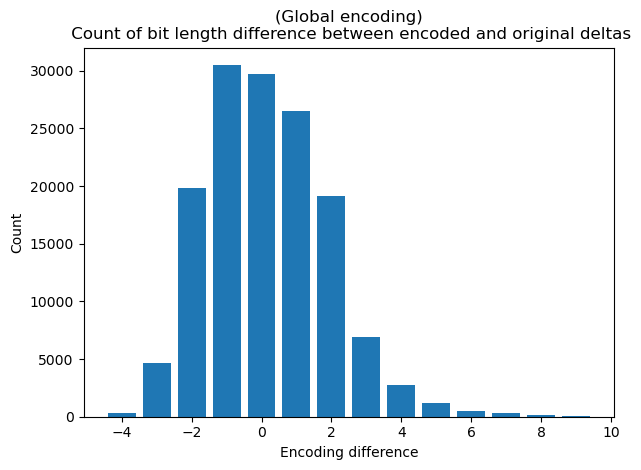

11it [00:00, 131.87it/s]


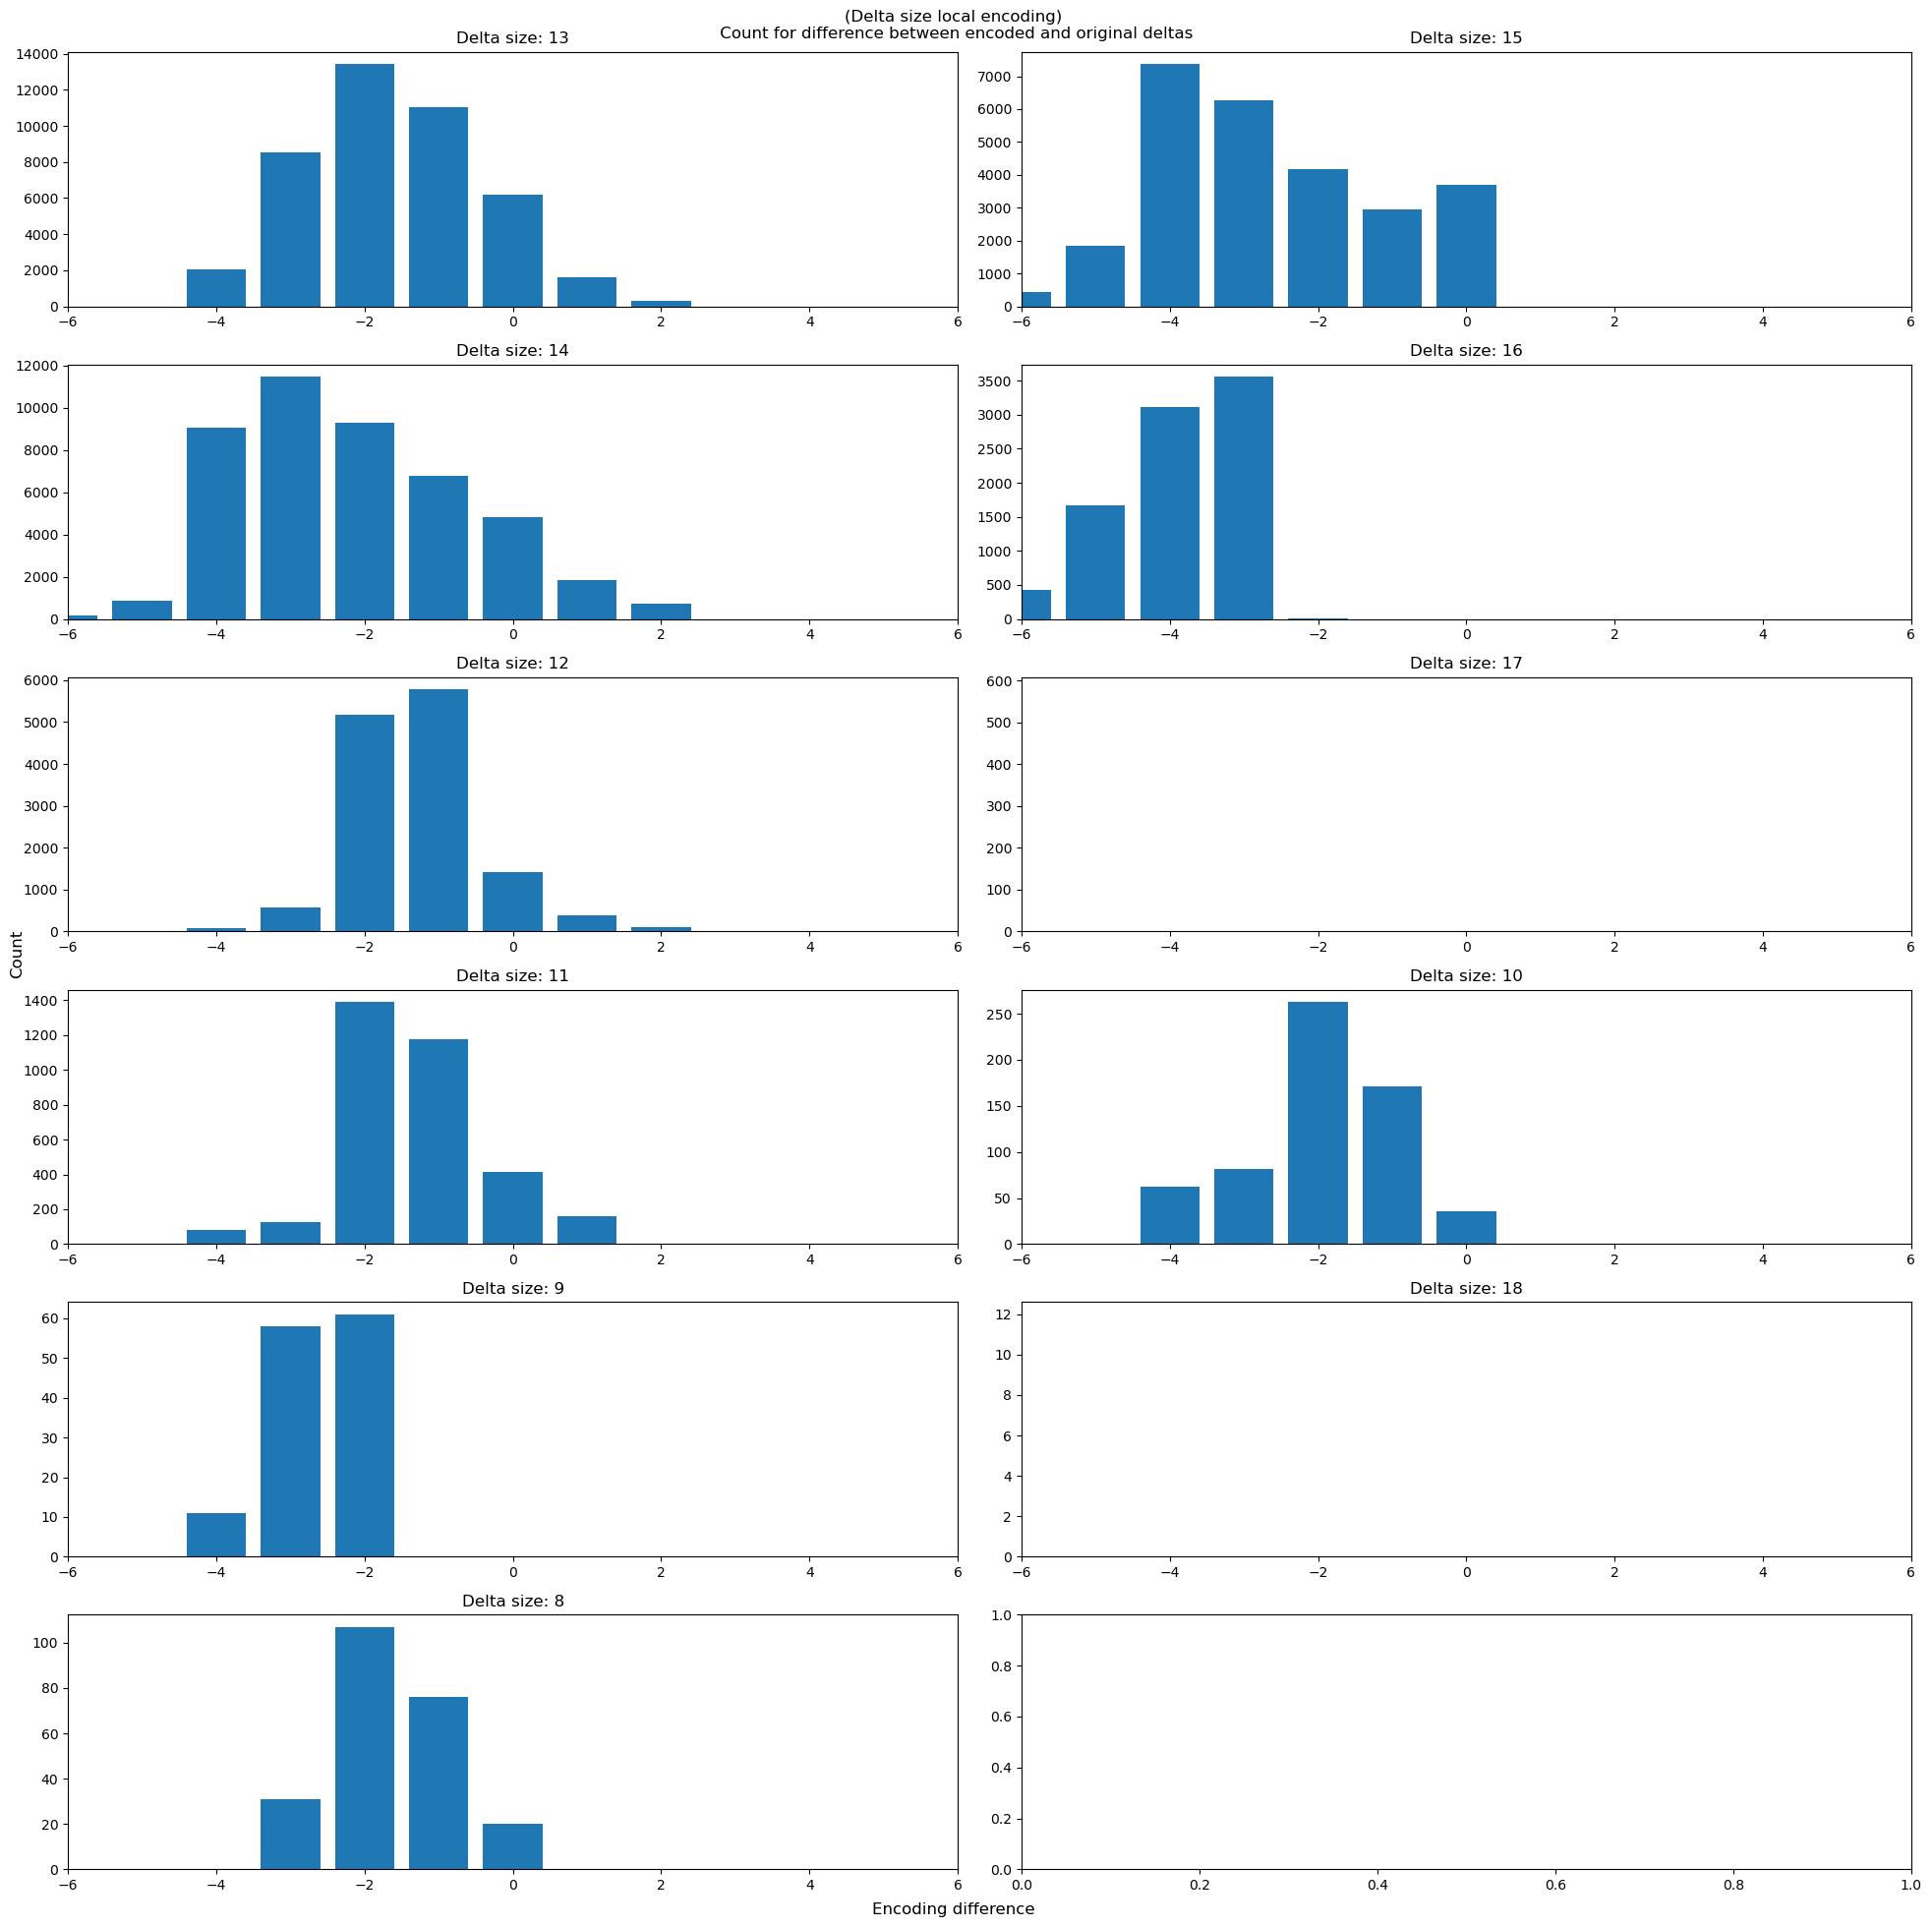

In [ ]:
plot_diff_count(delta_diff_count, "Count of bit length difference between encoded and original deltas")
plot_diff_count_by_bits(delta_diff_count_by_bits, "Count for difference between encoded and original deltas")

### Prefix Encoding Analysis

In [ ]:
def plot_bit_freqs(freqs, codes):
    #Plot global data
    dictionary = dict(sorted(freqs.items(), key=lambda x:-x[1]))
    plt.figure(figsize=(20,6))
    plt.bar(dictionary.keys(), dictionary.values())

    plt.title("(Global encoding)\n Prefix bits count -> Huffman codes")
    plt.xlabel("Bit sequence")
    plt.ylabel("Count")
    plt.xticks(plt.xticks()[0], ["{}  ->  {}".format(key,encode(key, codes)) for key in dictionary.keys()], rotation = 90)
    plt.tight_layout()
    plt.show()


def plot_bit_freq_by_bits(freq_by_bits, codes_by_bits):
    HEIGHT, WIDTH = len(freq_by_bits) // 2 + len(freq_by_bits) % 2, 2
    fig, axs = plt.subplots(HEIGHT, WIDTH, sharex=False, sharey=False)

    for idx, opt_delta in tqdm.tqdm(enumerate(sorted(freq_by_bits))):
        dictionary = dict(sorted(freq_by_bits[opt_delta].items(), key=lambda x:-x[1]))
        curr_codes = codes_by_bits[opt_delta]
        curr_ax_height, curr_ax_width = idx // 2, idx % 2
        axs[curr_ax_height, curr_ax_width].bar(dictionary.keys(), dictionary.values())
        axs[curr_ax_height, curr_ax_width].set_title("Geometry delta size: {}".format(opt_delta))   
        axs[curr_ax_height, curr_ax_width].set_xticklabels(["{}  ->  {}".format(key,encode(key, curr_codes)) for key in dictionary.keys()], rotation = 90)
    
    fig.suptitle("(Delta size local encoding) \n prefix bits count for geometries with different delta sizes -> Huffman code", fontsize=16)
    fig.supylabel('Count')
    fig.supxlabel('Bit sequence')
    fig.tight_layout()
    fig.set_figheight(4 * HEIGHT)
    fig.set_figwidth(20)
    fig.tight_layout(pad=0.1)
    plt.tight_layout()
    fig.subplots_adjust(top=0.9, bottom=0.2, left=0.1)
    plt.show()

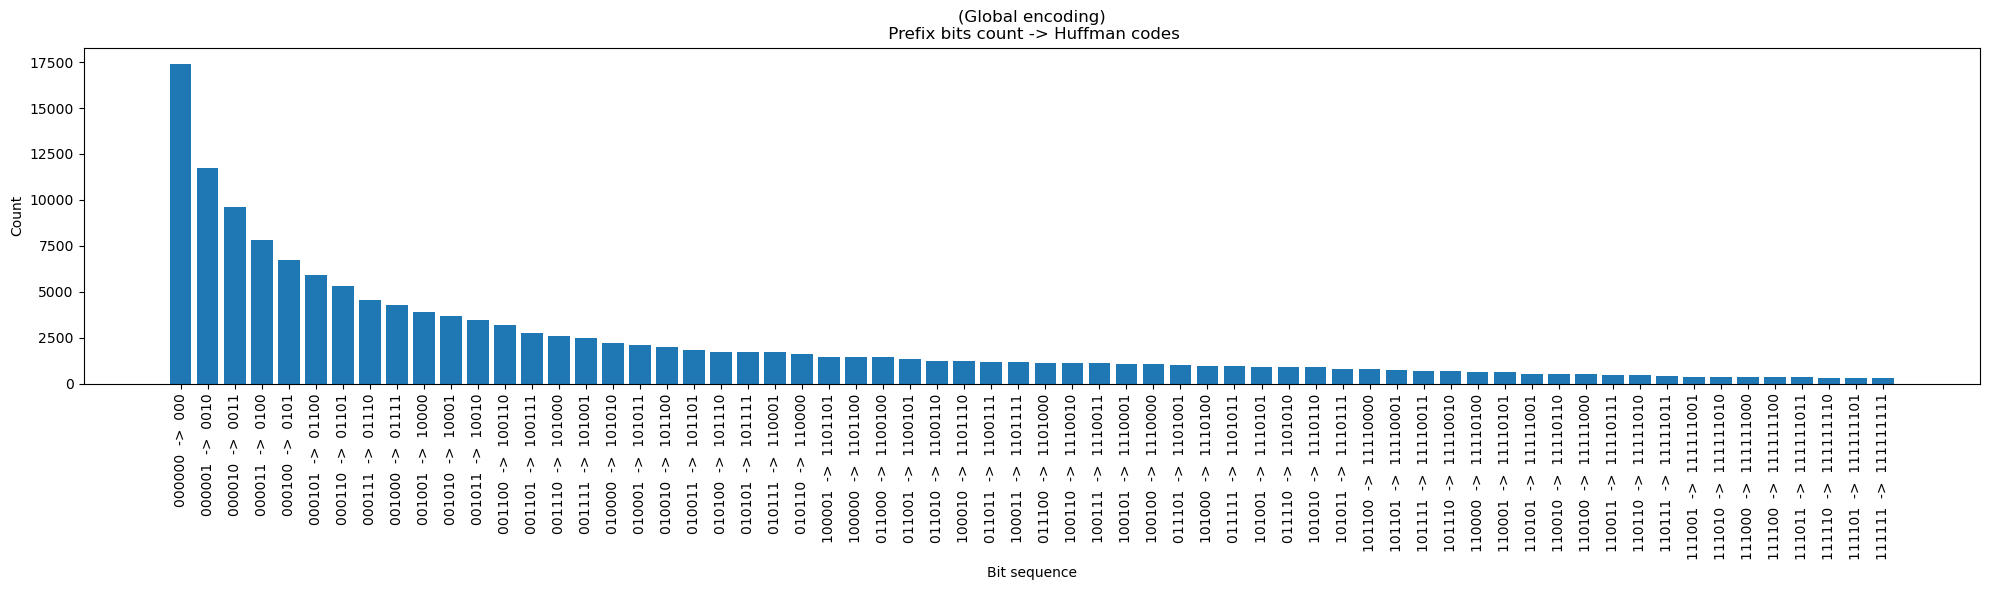

11it [00:01,  9.42it/s]


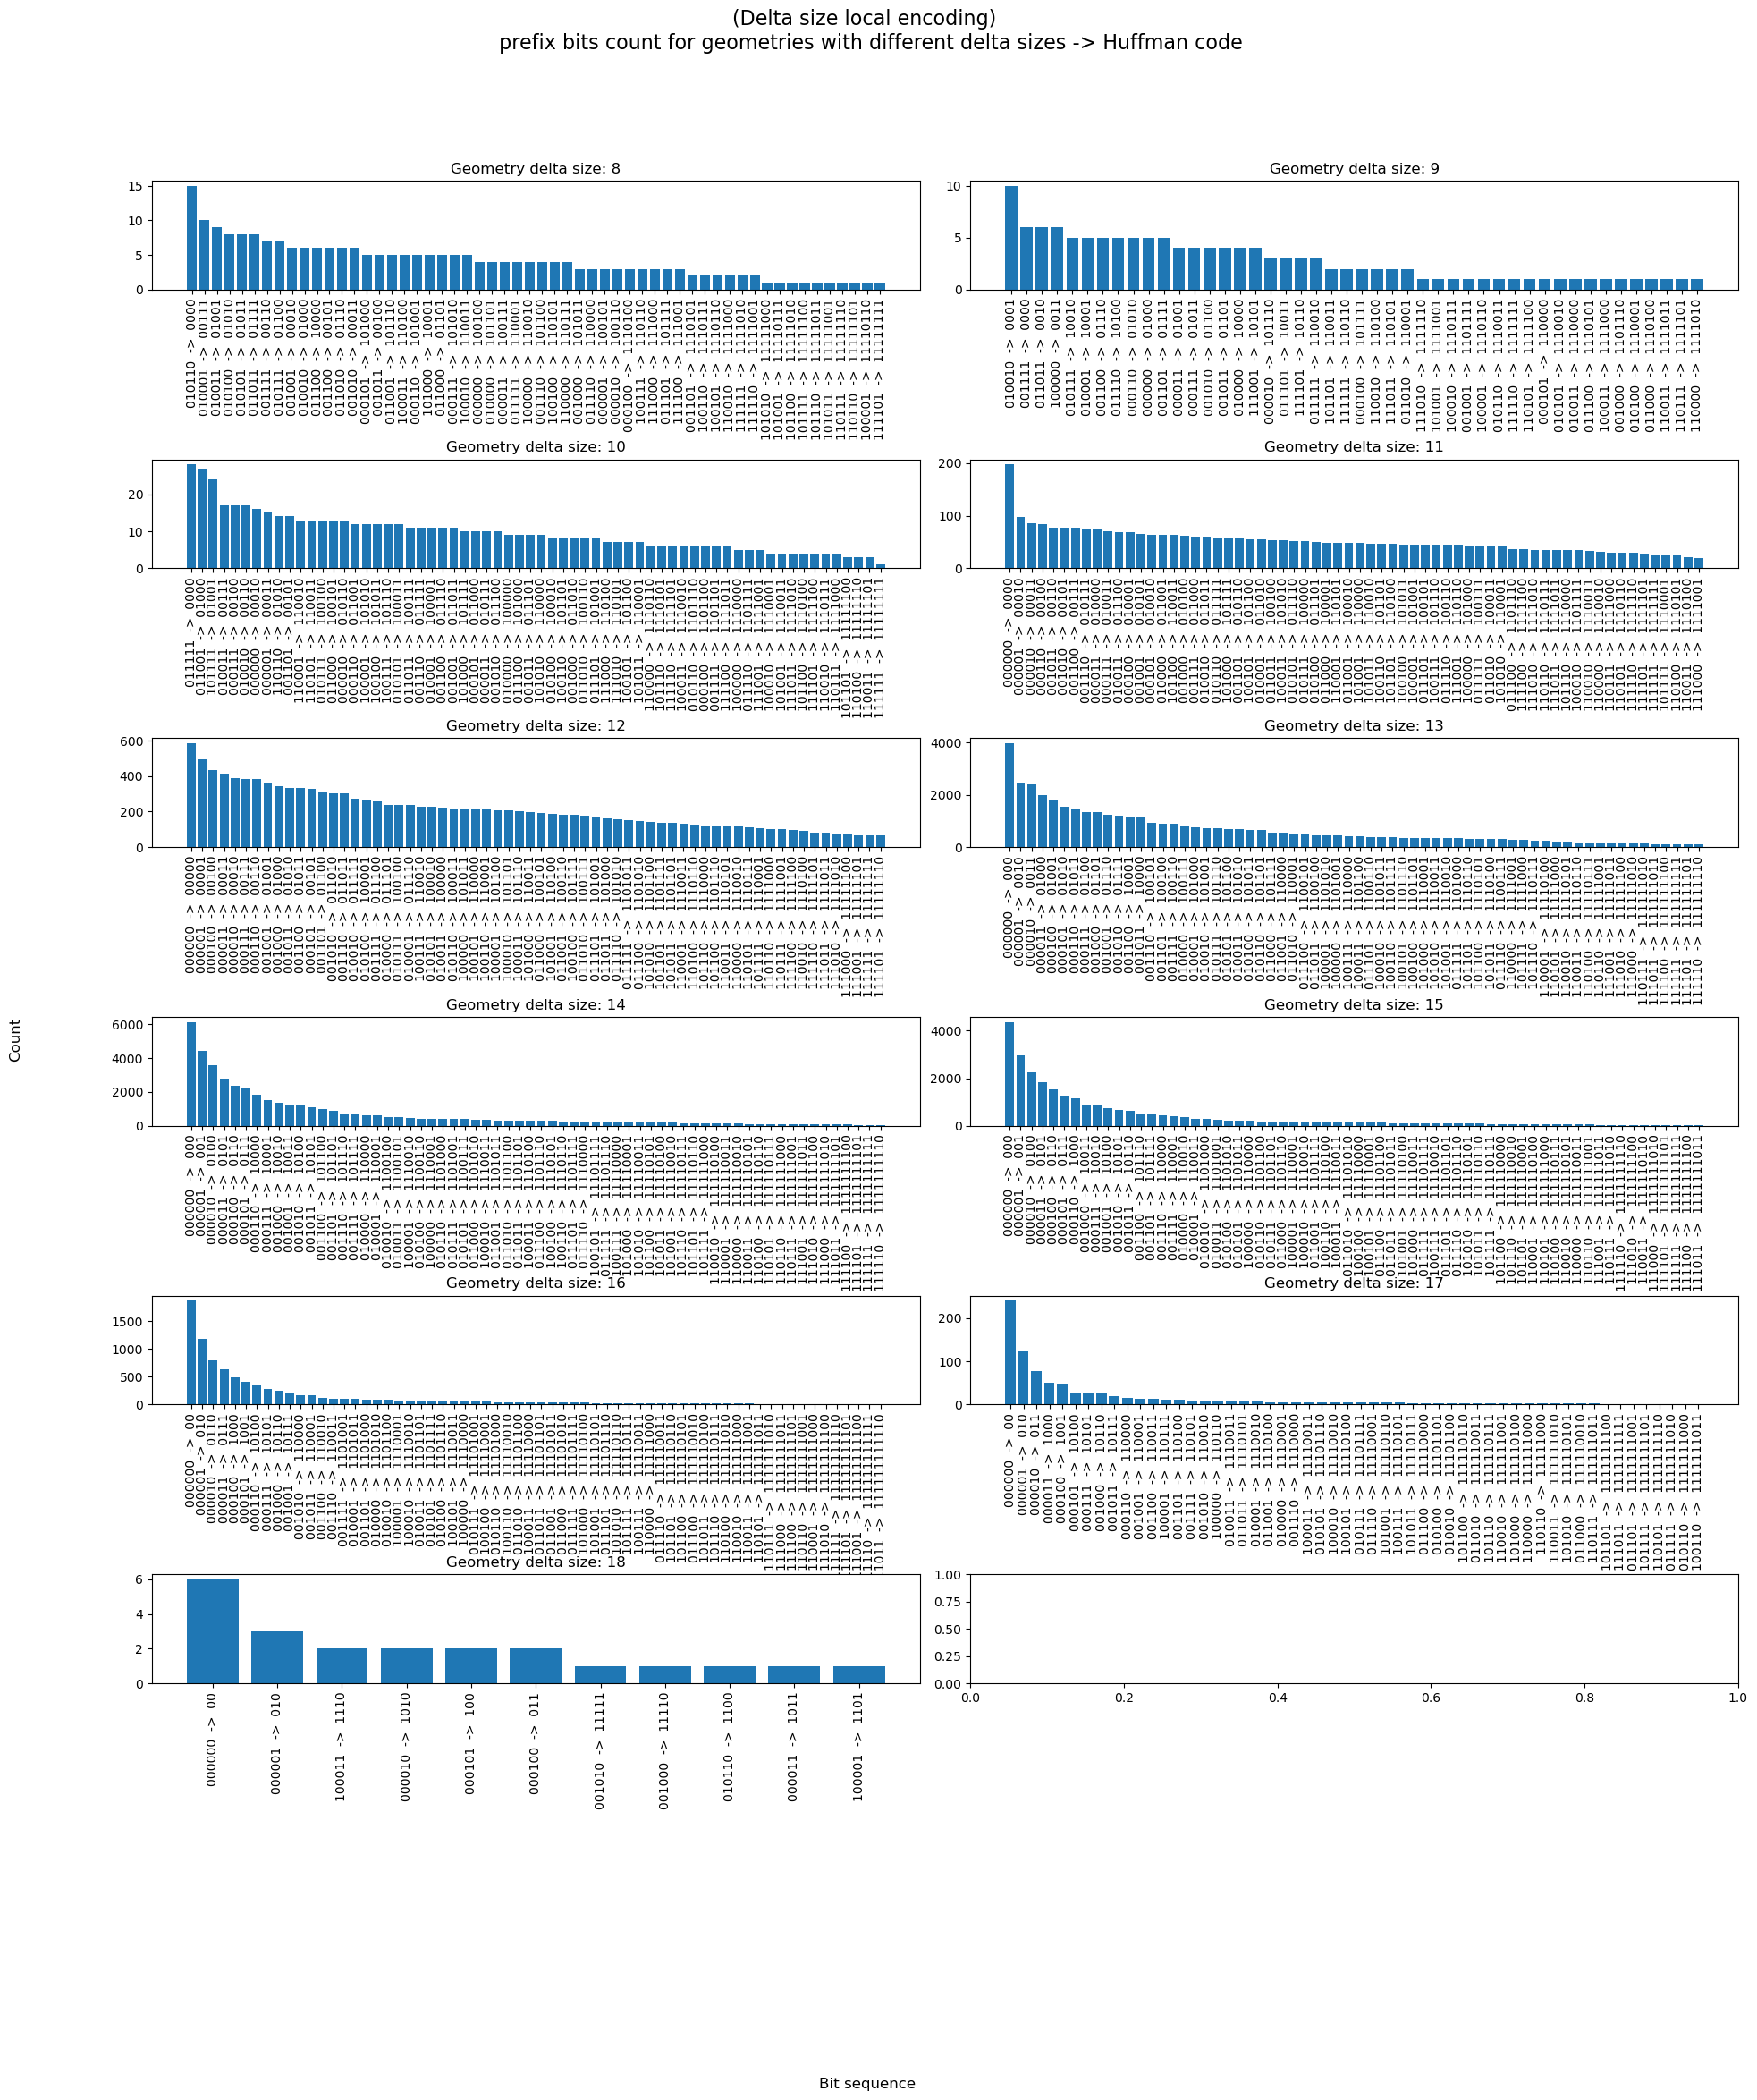

In [ ]:
plot_bit_freqs(prefix_freqs, prefix_codes)
plot_bit_freq_by_bits(prefix_freqs_by_bits, prefix_codes_by_bits)

In [ ]:
prefix_diff_count_by_bits = entropy_diff_calc_by_bits(prefix_codes_by_bits, prefix_freqs_by_bits)
prefix_diff_count = entropy_diff_calc(prefix_codes, prefix_freqs)

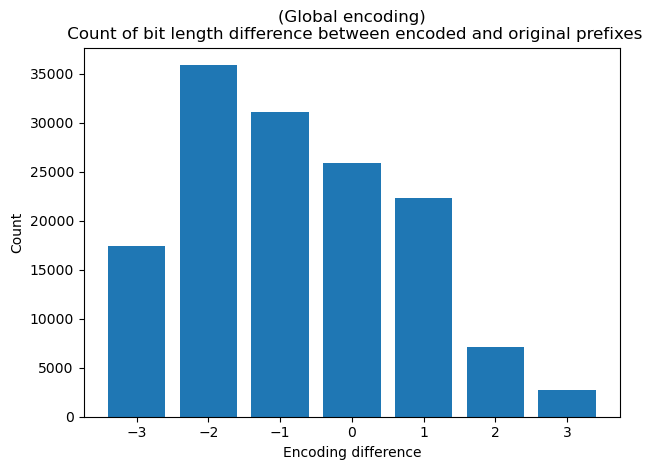

11it [00:00, 117.71it/s]


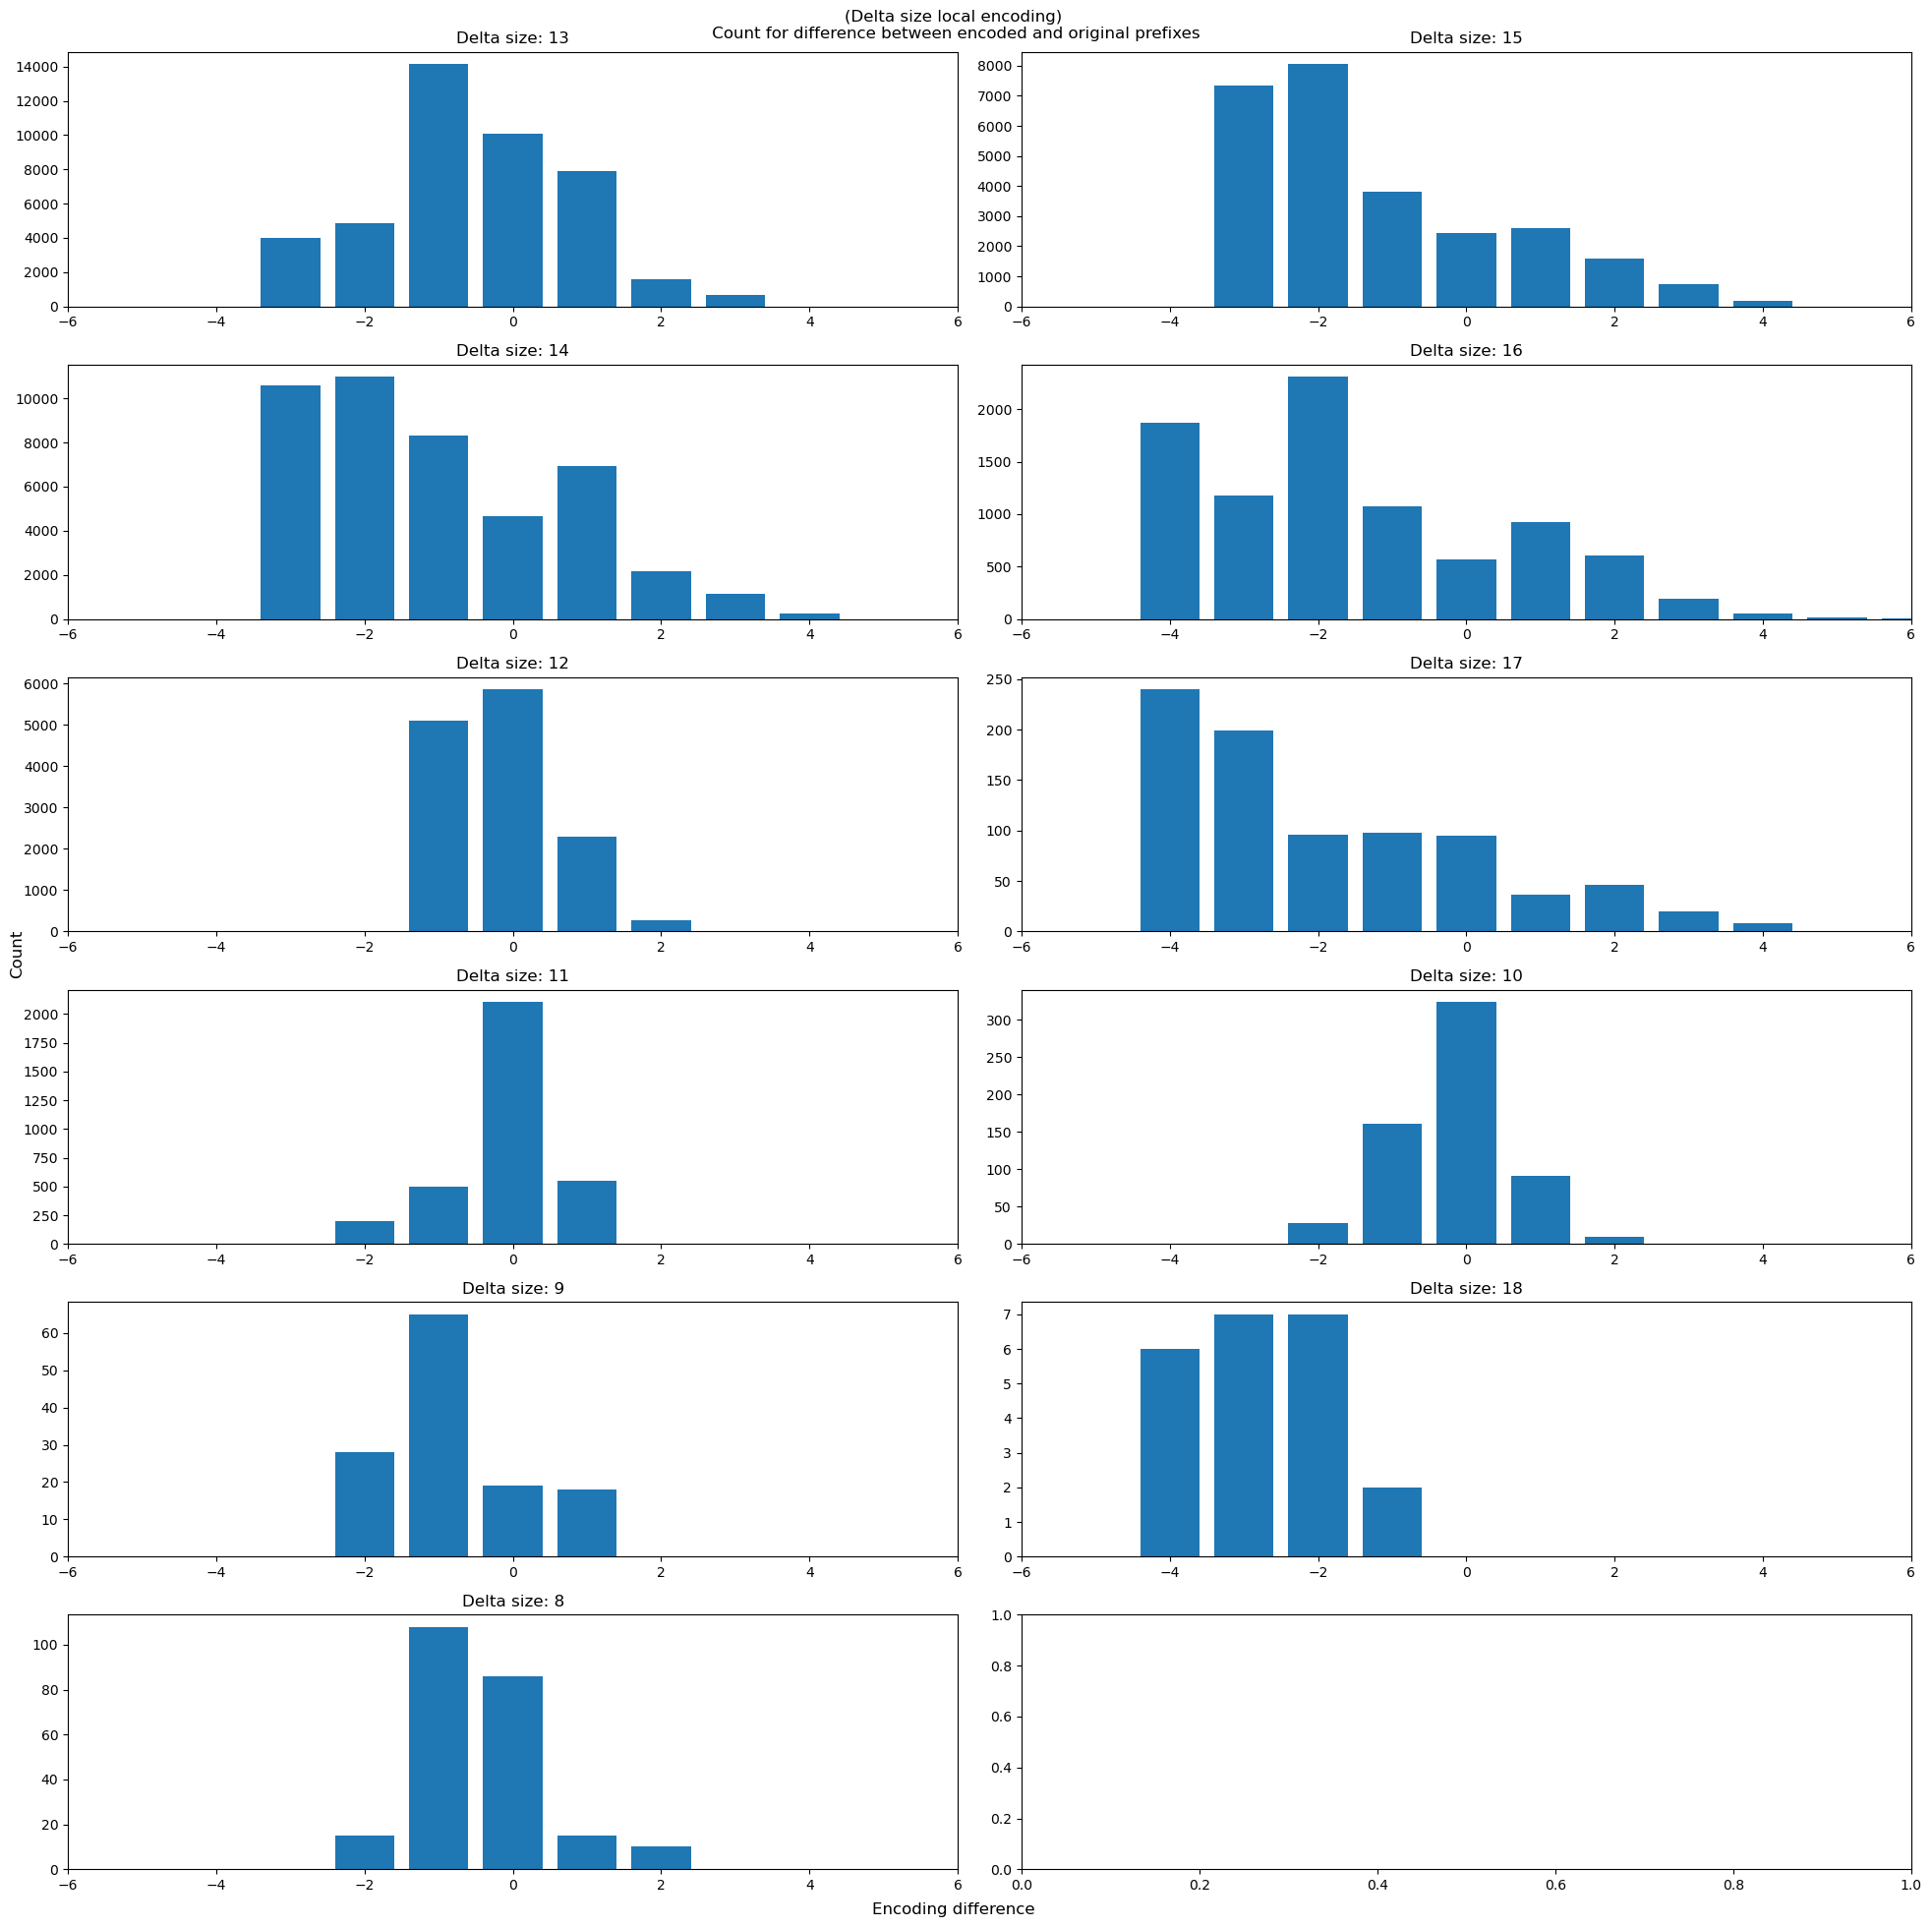

In [ ]:
plot_diff_count(prefix_diff_count, "Count of bit length difference between encoded and original prefixes")
plot_diff_count_by_bits(prefix_diff_count_by_bits, "Count for difference between encoded and original prefixes")

### Entropy encoding analysis

In [ ]:
def get_bit_count(bit_freqs, code_table = None):
    return sum([len(key if code_table == None else encode(key, code_table)) * value for key, value in bit_freqs.items()])

def get_geom_prefixes(geom_deltas_freqs):
    geom_prefix_freqs = defaultdict(int)
    for key in geom_deltas_freqs:
        geom_prefix_freqs[key[:PREFIX_LENGTH]] += geom_deltas_freqs[key]
    return geom_prefix_freqs

def geom_specific_codes(geom_idx, geom_deltas_freqs, geom_prefix_freqs, delta_codes_by_bits, prefix_codes_by_bits):
        geom_local_prefix_codes = get_entropy_codes(geom_prefix_freqs)
        geom_local_delta_codes = get_entropy_codes(geom_deltas_freqs)
        prefix_codes_by_bit_len = prefix_codes_by_bits[geom_optimal_sizes[geom_idx]]
        delta_codes_by_bit_len = delta_codes_by_bits[geom_optimal_sizes[geom_idx]]
        return geom_local_prefix_codes, geom_local_delta_codes, prefix_codes_by_bit_len, delta_codes_by_bit_len

In [ ]:
def get_entropy_data_per_geometry_df():
    geom_entropy_df = pd.DataFrame(columns=["geom_idx", 
                                            "delta_size",
                                            "prefix_size",
                                            "(global enc) delta_size",
                                            "(delta size local enc) delta_size",
                                            "(geom local enc) delta_size",
                                            "(global enc) prefix_size",
                                            "(delta size local enc) prefix_size",
                                            "(geom local enc) prefix_size"],index=[0])

    for geom_idx in delta_freqs_by_geometry:
        geom_deltas_freqs = {uint_to_ba(key, geom_optimal_sizes[geom_idx]).to01():value for key, value in delta_freqs_by_geometry[geom_idx].items()}
        geom_prefix_freqs = get_geom_prefixes(geom_deltas_freqs)
        
        codes = (geom_deltas_freqs, geom_prefix_freqs, delta_codes_by_bits, prefix_codes_by_bits)
        geom_local_prefix_codes, geom_based_delta_codes, geom_prefix_codes, geom_delta_codes = geom_specific_codes(geom_idx, *codes)
        
        geom_tot_delta_sizes =      get_bit_count(geom_deltas_freqs)
        geom_prefix_sizes =         get_bit_count(geom_prefix_freqs)
        
        enc_delta_sizes =           get_bit_count(geom_deltas_freqs, delta_codes)
        enc_delta_sizes_by_bits =   get_bit_count(geom_deltas_freqs, geom_delta_codes)
        enc_delta_sizes_by_geom =   get_bit_count(geom_deltas_freqs, geom_based_delta_codes)

        enc_prefix_sizes =          get_bit_count(geom_prefix_freqs, prefix_codes)
        enc_prefix_sizes_by_bits =  get_bit_count(geom_prefix_freqs, geom_prefix_codes)
        enc_prefix_sizes_by_geom =  get_bit_count(geom_prefix_freqs, geom_local_prefix_codes)
        
        new_row = pd.DataFrame({"geom_idx": geom_idx, 
                                "delta_size":geom_tot_delta_sizes, 
                                "prefix_size": geom_prefix_sizes, 

                                "(global enc) delta_size": enc_delta_sizes, 
                                "(delta size local enc) delta_size": enc_delta_sizes_by_bits,
                                "(geom local enc) delta_size": enc_delta_sizes_by_geom,

                                "(global enc) prefix_size": enc_prefix_sizes, 
                                "(delta size local enc) prefix_size": enc_prefix_sizes_by_bits, 
                                "(geom local enc) prefix_size": enc_prefix_sizes_by_geom}, index=[0])   

        geom_entropy_df = pd.concat([new_row,geom_entropy_df])

    geom_entropy_df["delta_size_excl_prefix"] = geom_entropy_df["delta_size"] - geom_entropy_df["prefix_size"] 
    return geom_entropy_df

In [ ]:
geom_entropy_df = get_entropy_data_per_geometry_df()
geom_entropy_df

,geom_idx,delta_size,prefix_size,(global enc) delta_size,(delta size local enc) delta_size,(geom local enc) delta_size,(global enc) prefix_size,(delta size local enc) prefix_size,(geom local enc) prefix_size,delta_size_excl_prefix
0,16489,4800,1920,4458,3725,2566,1349,1243,1091,2880
0,16488,330,132,333,284,100,123,126,87,198
0,16487,150,60,160,140,34,66,70,30,90
0,16486,308,132,301,266,100,115,116,82,176
0,16485,1417,654,1399,1199,730,552,558,502,763
...,...,...,...,...,...,...,...,...,...,...
0,9,60,24,63,55,8,24,26,8,36
0,7,330,132,328,277,100,110,111,78,198
0,3,364,168,367,317,134,143,148,110,196
0,1,312,144,293,248,108,103,107,63,168


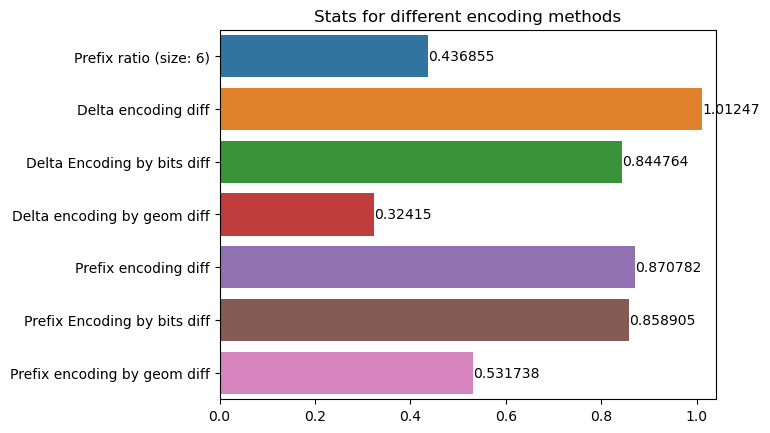

In [ ]:
prefix_ratio =                  geom_entropy_df["prefix_size"].sum() / geom_entropy_df["delta_size"].sum()
delta_encoding_diff =           geom_entropy_df["(global enc) delta_size"].sum() / geom_entropy_df["delta_size"].sum()
delta_encoding_by_bits_diff =   geom_entropy_df["(delta size local enc) delta_size"].sum() / geom_entropy_df["delta_size"].sum()
delta_encoding_by_geom_diff =   geom_entropy_df["(geom local enc) delta_size"].sum() / geom_entropy_df["delta_size"].sum()

prefix_encoding_diff =          geom_entropy_df["(global enc) prefix_size"].sum() / geom_entropy_df["prefix_size"].sum()
prefix_encoding_by_bits_diff =  geom_entropy_df["(delta size local enc) prefix_size"].sum() / geom_entropy_df["prefix_size"].sum()
prefix_encoding_by_geom_diff =  geom_entropy_df["(geom local enc) prefix_size"].sum() / geom_entropy_df["prefix_size"].sum()

bar_plot_dict= {u'Prefix ratio (size: {})'.format(PREFIX_LENGTH):prefix_ratio, 
                u'Delta encoding diff': delta_encoding_diff, 
                u'Delta Encoding by bits diff':delta_encoding_by_bits_diff, 
                u'Delta encoding by geom diff':delta_encoding_by_geom_diff, 
                u'Prefix encoding diff': prefix_encoding_diff, 
                u'Prefix Encoding by bits diff':prefix_encoding_by_bits_diff, 
                u'Prefix encoding by geom diff':prefix_encoding_by_geom_diff}

keys = list(bar_plot_dict.keys())
# get values in the same order as keys, and parse percentage values
vals = [bar_plot_dict[k] for k in keys];
fig = sns.barplot(x=vals, y=keys, orient="h");
plt.title("Stats for different encoding methods")
plt.xlim([0, 1]);
for i in fig.containers:
    fig.bar_label(i,)
plt.xlim([0, 1.04]);

### Entropy encoding on bitsequences in X% of cdf mass

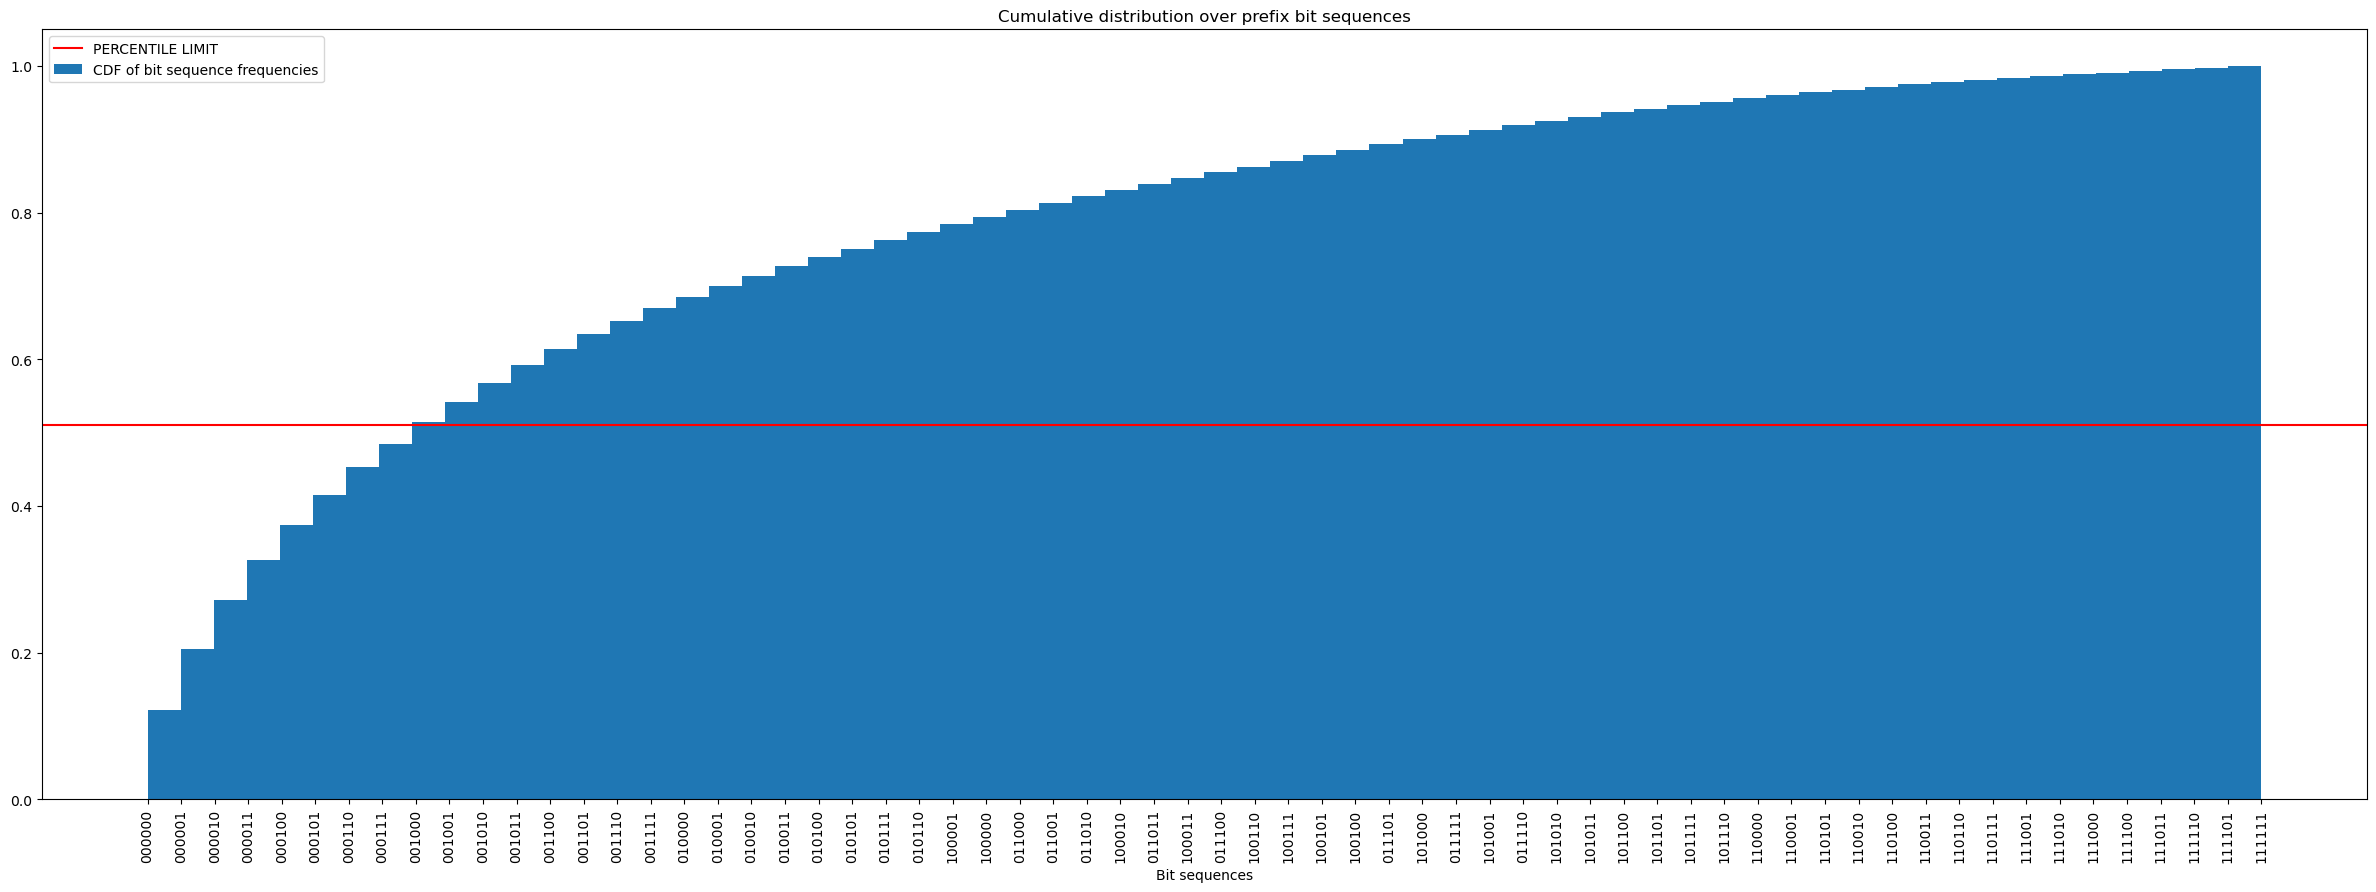

In [ ]:
def cdf_bit_frequency(freqs, title):
    plt.figure(figsize=(30,10))
    freqs_sorted = dict(sorted(freqs.items(), key=lambda x:-x[1]))
    plt.hist(x=freqs_sorted.keys(), bins = len(freqs_sorted.keys()) ,weights=freqs_sorted.values(), density=True, cumulative=True)
    plt.xticks(rotation=90);
    plt.axhline(y = PERCENTILE_MAX, color = 'r', linestyle = '-')
    plt.legend([ "PERCENTILE LIMIT","CDF of bit sequence frequencies"])
    plt.title(title)
    plt.xlabel("Cumulative density")
    plt.xlabel("Bit sequences")

    plt.show()

if PLOT_CDF_FREQS:
    cdf_bit_frequency(prefix_freqs, "Cumulative distribution over prefix bit sequences")

In [ ]:
def get_bit_sequences_inside_percentile(freqs):
    freqs_sorted = dict(sorted(freqs.items(), key=lambda x:-x[1]))
    total_size, cumulative_size  = sum(freqs_sorted.values()), 0
    keys_inside_percentile = []
    for key in freqs_sorted:
        cumulative_size += freqs_sorted[key]
        if cumulative_size / total_size > PERCENTILE_MAX:
            break
        else:
            keys_inside_percentile.append(key)
    return keys_inside_percentile

In [ ]:
#Get bit sequences inside percentile limit
prefix_in_perc =  get_bit_sequences_inside_percentile(prefix_freqs)
prefix_in_perc_by_bits = {opt_size:get_bit_sequences_inside_percentile(prefix_freqs_by_bits[opt_size]) for opt_size in prefix_freqs_by_bits}

deltas_in_perc =  get_bit_sequences_inside_percentile(delta_freqs)
delta_in_perc_by_bits = {opt_size:get_bit_sequences_inside_percentile(delta_freqs_by_bits[opt_size]) for opt_size in delta_freqs_by_bits}

In [ ]:
#Get frequencies of bit sequences inside percentile limit
prefix_freqs_in_perc = {key:prefix_freqs[key] for key in prefix_in_perc}
prefix_freqs_in_perc_by_bits = {opt_size:{key:prefix_freqs_by_bits[opt_size][key] for key in prefix_in_perc_by_bits[opt_size]} for opt_size in prefix_in_perc_by_bits}

delta_freqs_in_perc = {key:delta_freqs[key] for key in delta_freqs}
delta_freqs_in_perc_by_bits = {opt_size:{key:delta_freqs_by_bits[opt_size][key] for key in delta_in_perc_by_bits[opt_size]} for opt_size in delta_in_perc_by_bits}

In [ ]:
#Get codes for frequencies of bit sequences inside percentile limit
prefixes_in_perc_codes = get_entropy_codes(prefix_freqs_in_perc)
prefix_in_perc_codes_by_bits = {opt_size:get_entropy_codes(prefix_freqs_in_perc_by_bits[opt_size]) for opt_size in prefix_freqs_in_perc_by_bits}

delta_in_perc_codes = get_entropy_codes(delta_freqs_in_perc)
delta_in_perc_codes_by_bits = {opt_size:get_entropy_codes(delta_freqs_in_perc_by_bits[opt_size]) for opt_size in delta_freqs_in_perc_by_bits}

In [ ]:
def get_percentile_enc_size(codes, freqs, in_precentile, FOR_PREFIX):
    encoded_freqs,  unencoded_freqs = defaultdict(int), defaultdict(int)
    for key in freqs:
        key_temp = key
        key = key[:PREFIX_LENGTH] if FOR_PREFIX else key
        if key in in_precentile:
            encoded_freqs["1" + encode(key, codes)] += freqs[key_temp]
        else:
            encoded_freqs["0" + key] += freqs[key_temp]
        
        unencoded_freqs[key] += freqs[key_temp]
    
    encoded_size = get_bit_count(encoded_freqs)
    unencoded_size = get_bit_count(unencoded_freqs)
    return encoded_size, unencoded_size


def get_percentile_enc_size_by_bits(codes, freqs, in_precentile, FOR_PREFIX):
    encoded_size_by_bits,  unencoded_size_by_bits = {}, {}
    for opt_size in freqs:
        encoded_size, unencoded_size = get_percentile_enc_size(codes[opt_size], freqs[opt_size], in_precentile[opt_size], FOR_PREFIX)
        encoded_size_by_bits[opt_size] = encoded_size
        unencoded_size_by_bits[opt_size] = unencoded_size
    return encoded_size_by_bits, unencoded_size_by_bits

In [ ]:
def get_entropy_data_per_geometry_df_perc():

    #EE = "Entropy encoded"
    geom_percentile_entropy_df = pd.DataFrame(columns=[ "geom_idx", 
                                                        "delta_size",
                                                        "prefix_size",
                                                        "(global perc_enc) delta_size",
                                                        "(delta size local perc_enc) delta_size",
                                                        "(global perc_enc) prefix_size",
                                                        "(delta size local perc_enc) prefix_size"],index=[0])

    for geom_idx in delta_freqs_by_geometry:
        opt_size = geom_optimal_sizes[geom_idx]
        geom_deltas_freqs = {uint_to_ba(key, opt_size).to01():value for key, value in delta_freqs_by_geometry[geom_idx].items()}
        
        #Encoding whole deltas
        delta_encoded_size, delta_unencoded_size = get_percentile_enc_size(delta_in_perc_codes, geom_deltas_freqs, deltas_in_perc, FOR_PREFIX=False)
        delta_encoded_size_by_bits, _ = get_percentile_enc_size(delta_in_perc_codes_by_bits[opt_size], geom_deltas_freqs, delta_in_perc_by_bits[opt_size], FOR_PREFIX=False)
    
        prefix_encoded_size, prefix_unencoded_size = get_percentile_enc_size(prefixes_in_perc_codes, geom_deltas_freqs, prefix_in_perc, FOR_PREFIX=True)
        prefix_encoded_size_by_bits, _ = get_percentile_enc_size(prefixes_in_perc_codes, geom_deltas_freqs, prefix_in_perc, FOR_PREFIX=True)


        new_row = pd.DataFrame({"geom_idx": geom_idx, 
                                "delta_size": delta_unencoded_size, 
                                "prefix_size": prefix_unencoded_size, 
                                "(global perc_enc) delta_size": delta_encoded_size,
                                "(delta size local perc_enc) delta_size": delta_encoded_size_by_bits,
                                "(global perc_enc) prefix_size": prefix_encoded_size,
                                "(delta size local perc_enc) prefix_size": prefix_encoded_size_by_bits}, index=[0])   
        geom_percentile_entropy_df = pd.concat([new_row,geom_percentile_entropy_df])
    return geom_percentile_entropy_df

In [ ]:
geom_percentile_entropy_df = get_entropy_data_per_geometry_df_perc()

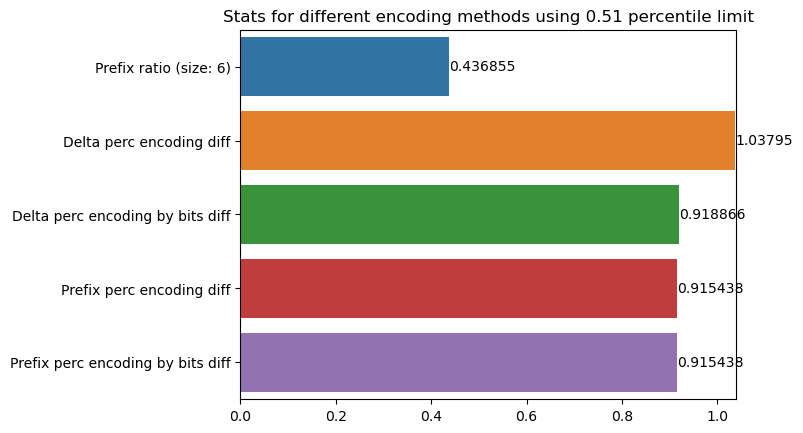

In [ ]:
prefix_ratio =                  geom_percentile_entropy_df["prefix_size"].sum() / geom_percentile_entropy_df["delta_size"].sum()
delta_encoding_diff =           geom_percentile_entropy_df["(global perc_enc) delta_size"].sum() / geom_percentile_entropy_df["delta_size"].sum()
delta_encoding_by_bits_diff =   geom_percentile_entropy_df["(delta size local perc_enc) delta_size"].sum() / geom_percentile_entropy_df["delta_size"].sum()

prefix_encoding_diff =          geom_percentile_entropy_df["(global perc_enc) prefix_size"].sum() / geom_percentile_entropy_df["prefix_size"].sum()
prefix_encoding_by_bits_diff =  geom_percentile_entropy_df["(delta size local perc_enc) prefix_size"].sum() / geom_percentile_entropy_df["prefix_size"].sum()

bar_plot_dict= {u'Prefix ratio (size: {})'.format(PREFIX_LENGTH):prefix_ratio, 
                u'Delta perc encoding diff': delta_encoding_diff, 
                u'Delta perc encoding by bits diff':delta_encoding_by_bits_diff, 
                u'Prefix perc encoding diff': prefix_encoding_diff, 
                u'Prefix perc encoding by bits diff':prefix_encoding_by_bits_diff}

keys = list(bar_plot_dict.keys())
# get values in the same order as keys, and parse percentage values
vals = [bar_plot_dict[k] for k in keys];
fig = sns.barplot(x=vals, y=keys, orient="h");
plt.title("Stats for different encoding methods using {} percentile limit".format(PERCENTILE_MAX))

for i in fig.containers:
    fig.bar_label(i,)
plt.xlim([0, 1.04]);